In [1]:
import sys
sys.path.append('../scripts/')

In [4]:
import pandas as pd
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from constants import mlp_features

## DATA EXPLORATION THINGS

(1064,) (1064,)
1.4962630627009552
1.284446814663864


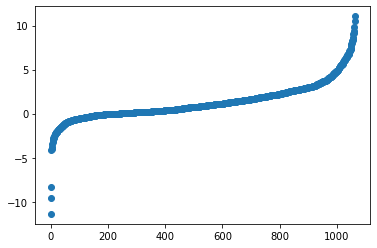

In [5]:
df = pd.read_csv(mlp_features)
df.drop(columns=['mut', 'Unnamed: 0'], inplace=True)
x, y = np.array(df.iloc[:, 1:-1]), np.array(df.iloc[:, -1])
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(x_tr, y_tr)
y_pred = reg.predict(x_te)
print(y_te.shape, y_pred.shape)
print(np.mean(np.abs((y_pred - y_te))))
print(y_te.mean())
plt.scatter(np.arange(len(y_te)), np.sort(y_te))

## Distance Matrix, example PDB

In [6]:
import numpy as np
from pathlib import Path
import parmed as pmd
import simtk.unit as su
import simtk.openmm as so
from pdbfixer import PDBFixer
from simtk.openmm.app import PDBFile

In [7]:
pdb_path='../data/pdbs_wt/'
fname='1A22_A_B.pdb'

clean PDB

In [3]:
pdb = pmd.load_file(pdb_path + fname)
pdb.save('/tmp/' + fname, overwrite=True)

fixer = PDBFixer(filename='/tmp/' + fname)
Path('/tmp/' + fname).unlink()
fixer.findMissingResidues()
fixer.findNonstandardResidues()
# print(f'number of non-standard residues in {fname}: {len(fixer.nonstandardResidues)}')
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(False)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(7.0)

init simulation system

In [4]:
forcefield = so.app.ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
system = forcefield.createSystem(fixer.topology, nonbondedMethod=so.app.NoCutoff)
param = pmd.openmm.load_topology(fixer.topology, system=system, xyz=fixer.positions)

get chain information

In [5]:
# get indices of atoms for the 2 interacting subunits
base_fname = fname.split('.')[0]
sub_unit_chains = [[char for char in subchain] for subchain  in base_fname.split('_')[1:3]]
print(f'chains: {sub_unit_chains}')
ids0, ids1 = (np.where(param.to_dataframe()['chain'].isin(cids))[0] for cids in sub_unit_chains)

chains: [['A'], ['B']]


#### run simulation

In [6]:
# constants
eps0 = 8.8541878128e-12 * su.farad * su.meter**-1
e = 1.60217662e-19 * su.coulomb
N = 6.02214179e23 * su.mole**-1 # Avogadro

# scaling factors
k0 = (N * (e*e) / (4.0 * np.pi * eps0))

# get nonbonded interactions parameters for all atoms (Lennard-Jones and electrostatics)
epsilon = np.array([a.epsilon for a in param.atoms])
sigma = np.array([a.sigma for a in param.atoms])
charge = np.array([a.charge for a in param.atoms])

# pairwise epsilon with units
E = np.sqrt(epsilon[ids0].reshape(-1,1) * epsilon[ids1].reshape(1,-1)) * param.atoms[0].uepsilon.unit

# pairwise sigma with units
S = 0.5*(sigma[ids0].reshape(-1,1) + sigma[ids1].reshape(1,-1)) * param.atoms[0].usigma.unit

# pairwise partial charges
Q = charge[ids0].reshape(-1,1) * charge[ids1].reshape(1,-1)

# setup MD engine
integrator = so.LangevinIntegrator(300*su.kelvin, 1/su.picosecond, 0.002*su.picoseconds)
platform = so.Platform.getPlatformByName('CUDA')
simulation = so.app.Simulation(param.topology, system, integrator, platform)

# set atom coordinates
simulation.context.setPositions(param.get_coordinates()[0] * su.angstrom)

# minimize energy
simulation.minimizeEnergy()


get atom coordinates and compute distance matrix between subunits

In [7]:
state = simulation.context.getState(getPositions=True)
xyz = state.getPositions(asNumpy=True)
D = np.linalg.norm(np.expand_dims(xyz[ids0], 1) - np.expand_dims(xyz[ids1], 0), axis=2) * su.angstrom

visualize distance matrix. The rows correspond to the atoms in protein 1, while the collumns correspond to the atoms in protein 2

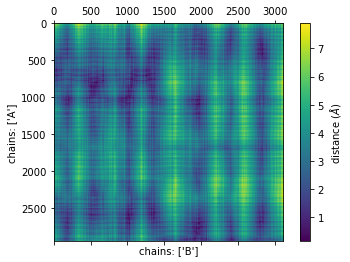

In [20]:
import matplotlib.pyplot as plt
figure = plt.figure() 
axes = figure.add_subplot(111) 

axes.set_ylabel(f'chains: {sub_unit_chains[0]}')
axes.set_xlabel(f'chains: {sub_unit_chains[1]}')

caxes = axes.matshow(D) 
cbar = figure.colorbar(caxes) 
cbar.ax.set_ylabel(r'distance ($\AA$)')
  
plt.show() 

In [21]:
D.shape

(2949, 3108)

choose the proper submatrix for the features. A proper submatrix should represent the most important atom-atom interactions between the proteins.

In [36]:
n_interactions = 256

min_i = np.argmin(D)
min_r, min_c = int(min_i/D.shape[1]), min_i%D.shape[1]
print(f'minimum distance: {np.min(D)}    position: {(min_r, min_c)}')

ids0_min, ids0_max = min_r-n_interactions/2, min_r+n_interactions/2
ids1_min, ids1_max = min_c-n_interactions/2, min_c+n_interactions/2

if ids0_min < 0:
    ids0_max -= ids0_min
    ids0_min = 0
elif ids0_max >= D.shape[0]:
    ids0_min -= ids0_max - D.shape[0] + 1
    ids0_max = D.shape[0]-1
    
if ids1_min < 0:
    ids1_max -= ids1_min
    ids1_min = 0
elif ids1_max >= D.shape[1]:
    ids1_min -= ids1_max - D.shape[1] + 1
    ids1_max = D.shape[1]-1

ids0_interacting = np.arange(ids0_min, ids0_max, dtype=np.int32)
ids1_interacting = np.arange(ids1_min, ids1_max, dtype=np.int32)

minimum distance: 0.1581961122069152 A    position: (2933, 2404)


plot submatrix

In [37]:
sub_D = D[np.ix_(ids0_interacting, ids1_interacting)]

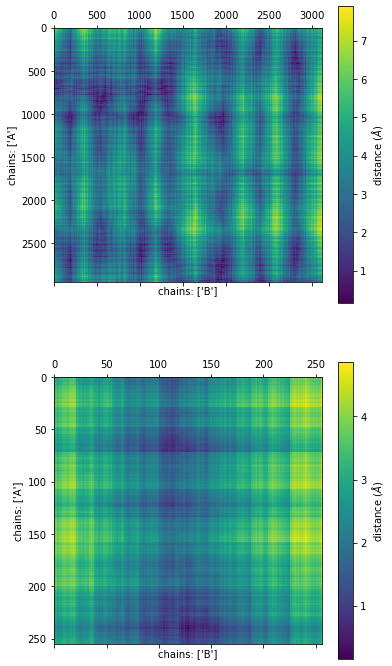

In [38]:
figure = plt.figure(figsize=(6,12)) 
axes = figure.add_subplot(211) 

axes.set_ylabel(f'chains: {sub_unit_chains[0]}')
axes.set_xlabel(f'chains: {sub_unit_chains[1]}')

caxesD = axes.matshow(D) 
cbar = figure.colorbar(caxesD) 
cbar.ax.set_ylabel(r'distance ($\AA$)')

axes = figure.add_subplot(212) 

axes.set_ylabel(f'chains: {sub_unit_chains[0]}')
axes.set_xlabel(f'chains: {sub_unit_chains[1]}')

caxes = axes.matshow(sub_D) 
cbar = figure.colorbar(caxes) 
cbar.ax.set_ylabel(r'distance ($\AA$)')

# plt.tight_layout()
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# cbar = figure.colorbar(caxesD, cax=cax)
# cbar.ax.set_ylabel(r'distance ($\AA$)')

plt.show() 

# PCA

In [12]:
from pathlib import Path

from constants import mut_features_path, wt_features_path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

consider only distance matrices,

In [17]:
# wild-types
wt_data = []
for i, f in enumerate(Path(wt_features_path).glob('[!.]*.npy')):
    fname = f.name
    wt_features = np.load(wt_features_path+fname)
    wt_data.append(wt_features[2].ravel())
# mutants
mut_data = []
for i, f in enumerate(Path(mut_features_path).glob('[!.]*.npy')):
    fname = f.name
    mut_features = np.load(mut_features_path+fname)
    mut_data.append(mut_features[2].ravel())

In [18]:
np.array(mut_data).shape, np.array(wt_data).shape

((5699, 65536), (333, 65536))

In [19]:
wt_N = len(wt_data)
data = StandardScaler().fit_transform(np.r_[wt_data, mut_data])

pca = PCA(n_components=10)
data_xyz = pca.fit_transform(data)[:,:3]

In [20]:
f'shape of PCA data: {data_xyz.shape}    no. of wild-types: {wt_N}'

'shape of PCA data: (6032, 3)    no. of wild-types: 333'

plot percentage of variation of each PC

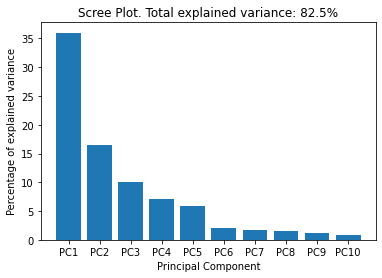

In [21]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
total_var = per_var.sum()
labels = [f'PC{i}' for i in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal Component')
plt.title(f'Scree Plot. Total explained variance: {total_var}%')
plt.show()

2D plot

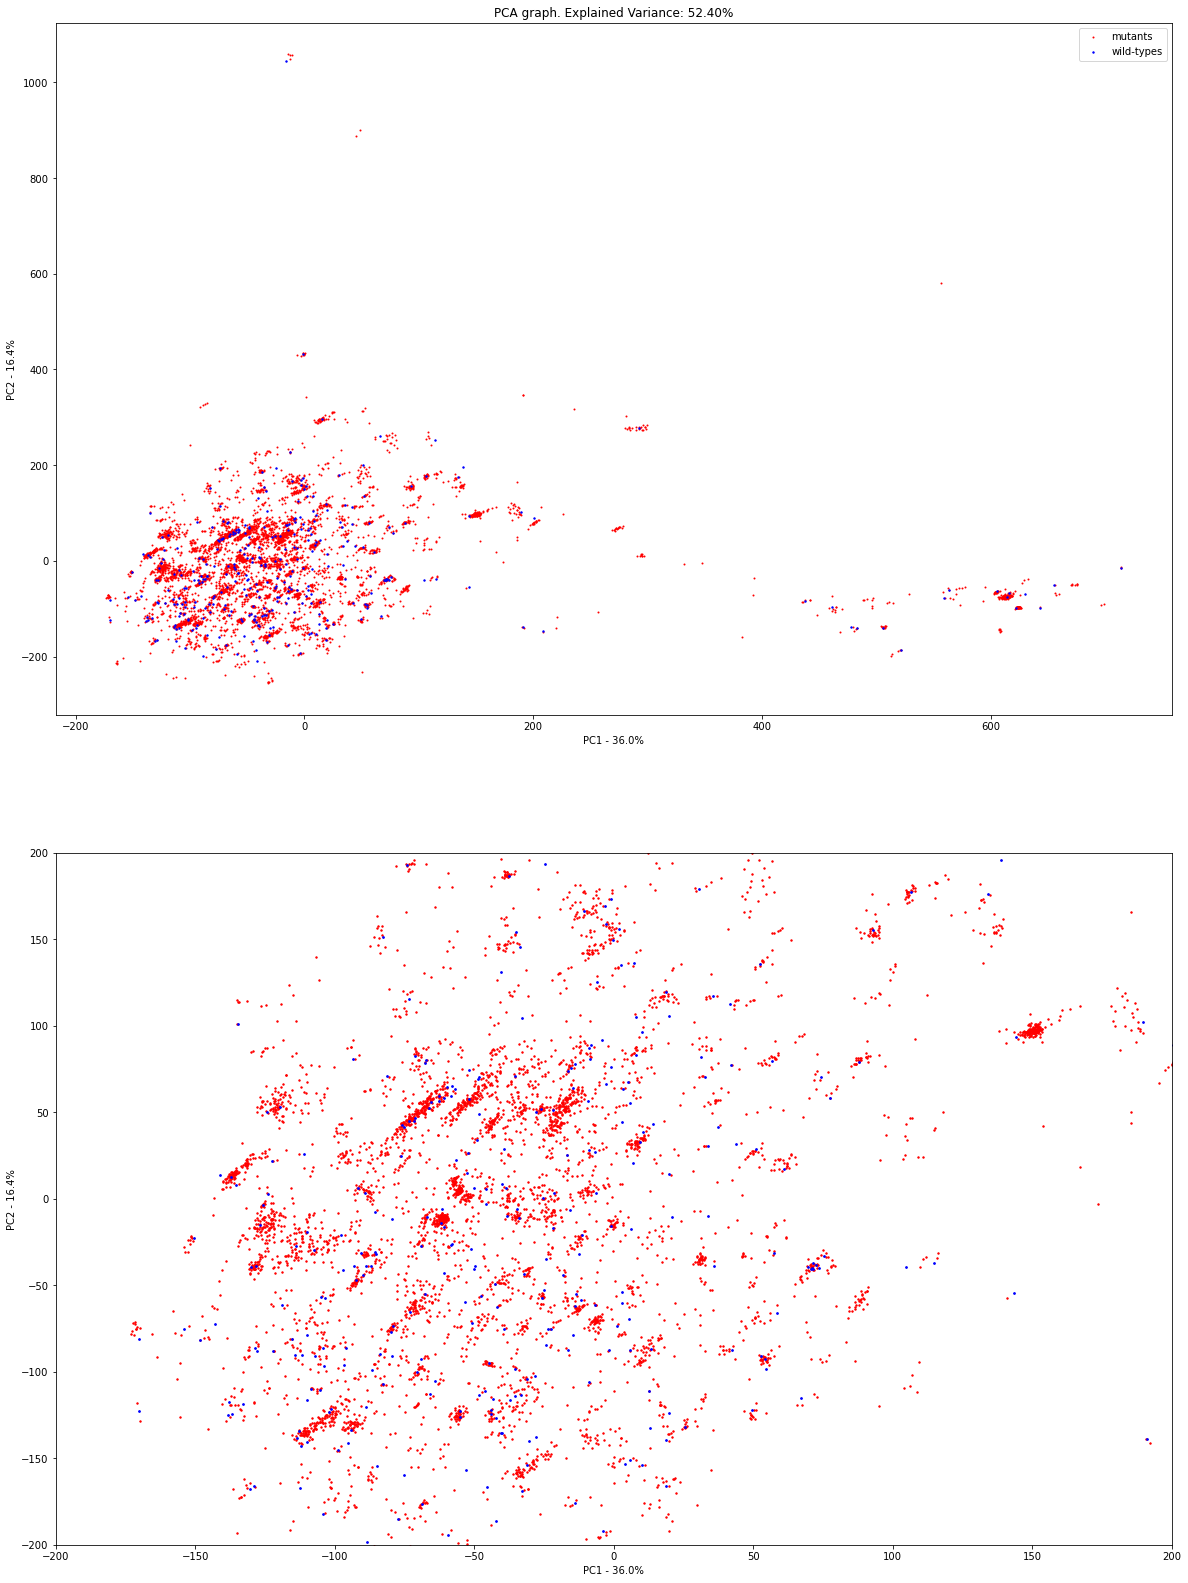

In [22]:
fig = plt.figure(figsize=(20,2*14))

ax = fig.add_subplot(211)
# mutant
ax.scatter(data_xyz[wt_N:,0],data_xyz[wt_N:,1], c='red', s=1)
# wild-type
ax.scatter(data_xyz[:wt_N,0],data_xyz[:wt_N,1], c='blue', s=2)
ax.set_xlabel(f'PC1 - {per_var[0]}%')
ax.set_ylabel(f'PC2 - {per_var[1]}%')

exp_var = per_var[0]+per_var[1]
plt.title(f'PCA graph. Explained Variance: {exp_var:.2f}%')
plt.legend(['mutants', 'wild-types'])

ax2 = fig.add_subplot(212)
# mutant
ax2.scatter(data_xyz[wt_N:,0],data_xyz[wt_N:,1], c='red', s=2)
# wild-type
ax2.scatter(data_xyz[:wt_N,0],data_xyz[:wt_N,1], c='blue', s=3)
ax2.set_xlim(-200,200)
ax2.set_ylim(-200,200)
ax2.set_xlabel(f'PC1 - {per_var[0]}%')
ax2.set_ylabel(f'PC2 - {per_var[1]}%')

plt.show()

3D plot

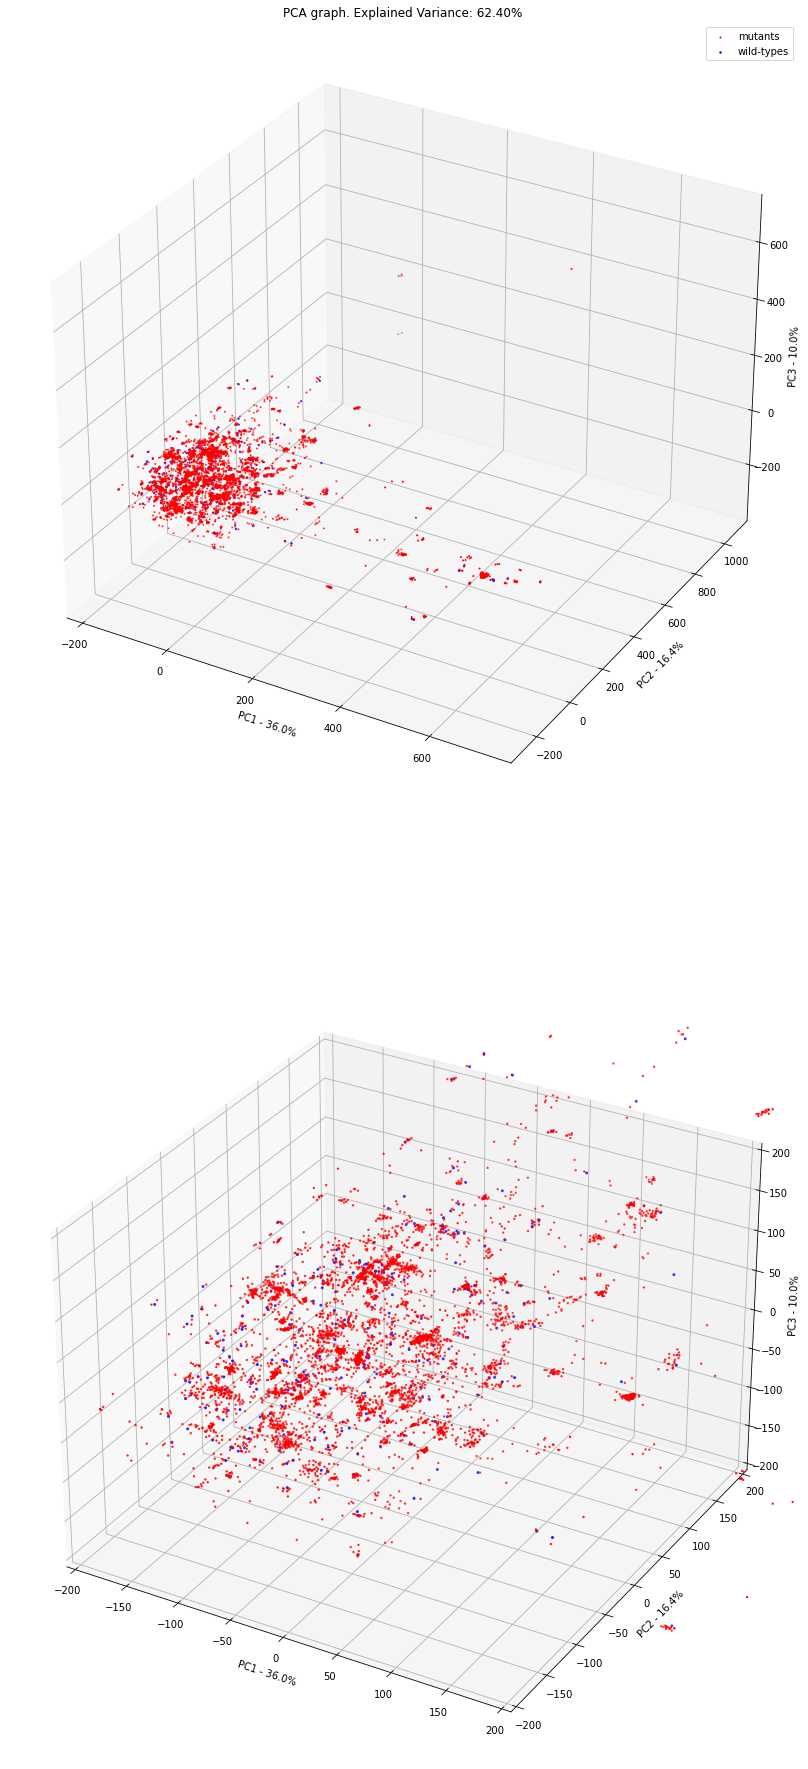

In [23]:
fig = plt.figure(figsize=(32,2*16))
ax = fig.add_subplot(211, projection='3d')
# mutant
ax.scatter(data_xyz[wt_N:,0],data_xyz[wt_N:,1],data_xyz[wt_N:,2], c='red', s=1)
# wild-type
ax.scatter(data_xyz[:wt_N,0],data_xyz[:wt_N,1],data_xyz[:wt_N,2], c='blue', s=2)
exp_var = per_var[0]+per_var[1]+per_var[2]
plt.title(f'PCA graph. Explained Variance: {exp_var:.2f}%')
ax.set_xlabel(f'PC1 - {per_var[0]}%')
ax.set_ylabel(f'PC2 - {per_var[1]}%')
ax.set_zlabel(f'PC3 - {per_var[2]}%')
plt.legend(['mutants', 'wild-types'])

ax2 = fig.add_subplot(212, projection='3d')
# mutant
ax2.scatter(data_xyz[wt_N:,0],data_xyz[wt_N:,1],data_xyz[wt_N:,2], c='red', s=2)
# wild-type
ax2.scatter(data_xyz[:wt_N,0],data_xyz[:wt_N,1],data_xyz[:wt_N,2], c='blue', s=4)
ax2.set_xlabel(f'PC1 - {per_var[0]}%')
ax2.set_ylabel(f'PC2 - {per_var[1]}%')
ax2.set_zlabel(f'PC3 - {per_var[2]}%')
ax2.set_xlim(-200,200)
ax2.set_ylim(-200,200)
ax2.set_zlim(-200,200)

plt.show()